# Tarea 1. Niveles del lenguaje
# Vázquez Martínez Fredin Alberto

## Información anterior para poder realizar la tarea

In [ ]:
import heapq
from nltk.metrics import edit_distance
from nltk.util import ngrams
from nltk.metrics import jaccard_distance

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter

from rich import print as rprint
from rich.columns import Columns
from rich.panel import Panel
from rich.text import Text

import http

import requests as r
from pprint import pprint as pp
import pandas as pd
import numpy as np

In [ ]:
IPA_URL = "https://raw.githubusercontent.com/open-dict-data/ipa-dict/master/data/{lang}.txt"

In [ ]:
# Dejando como idiomas con alfabeto latino

lang_codes = {
    # "ar": "Arabic (Modern Standard)",  # Usa el alfabeto árabe

    "de": "German",  # Alfabeto latino
    "en_UK": "English (Received Pronunciation)",  # Alfabeto latino
    "en_US": "English (General American)",  # Alfabeto latino
    "eo": "Esperanto",  # Alfabeto latino
    "es_ES": "Spanish (Spain)",  # Alfabeto latino
    "es_MX": "Spanish (Mexico)",  # Alfabeto latino

    # "fa": "Persian",  # Usa el alfabeto persa (derivado del árabe)

    "fi": "Finnish",  # Alfabeto latino
    "fr_FR": "French (France)",  # Alfabeto latino
    "fr_QC": "French (Québec)",  # Alfabeto latino
    "is": "Icelandic",  # Alfabeto latino

    # "ja": "Japanese",  # Usa kanji, hiragana y katakana

    "jam": "Jamaican Creole",  # Alfabeto latino

    # "km": "Khmer",  # Usa el alfabeto jemer
    # "ko": "Korean",  # Usa el hangul

    "ma": "Malay (Malaysian and Indonesian)",  # Alfabeto latino
    "nb": "Norwegian Bokmål",  # Alfabeto latino
    "nl": "Dutch",  # Alfabeto latino

    # "or": "Odia",  # Usa el alfabeto odia

    "ro": "Romanian",  # Alfabeto latino
    "sv": "Swedish",  # Alfabeto latino
    "sw": "Swahili",  # Alfabeto latino

    # "tts": "Isan",  # Usa el alfabeto tailandés

    "vi_C": "Vietnamese (Central)",  # Usa el alfabeto latino con diacríticos
    "vi_N": "Vietnamese (Northern)",  # Usa el alfabeto latino con diacríticos
    "vi_S": "Vietnamese (Southern)",  # Usa el alfabeto latino con diacríticos

    # "yue": "Cantonese",  # Usa caracteres chinos
    # "zh_hans": "Mandarin (Simplified)",  # Usa caracteres chinos simplificados
    # "zh_hant": "Mandarin (Traditional)"  # Usa caracteres chinos tradicionales
}

iso_lang_codes = list(lang_codes.keys())

In [ ]:
def get_formated_string(code: str, name: str):
    return f"[b]{name}[/b]\n[yellow]{code}"

def parse_response(response: str) -> dict:
    """Parse text response from ipa-dict to python dict

    Each row have the format:
    [WORD][TAB]/[IPA]/(, /[IPA]/)?

    Parameters
    ----------
    response: str
        ipa-dict raw text

    Returns
    -------
    dict:
        A dictionary with the word as key and the phonetic
        representations as value
    """
    ipa_list = response.rstrip().split("\n")
    result = {}
    for item in ipa_list:
        if item == '':
            continue
        item_list = item.split("\t")
        result[item_list[0]] = item_list[1]
    return result


def download_ipa_corpus(iso_lang: str) -> str:
    """Get ipa-dict file from Github

    Parameters:
    -----------
    iso_lang:
        Language as iso code

    Results:
    --------
    dict:
        Dictionary with words as keys and phonetic representation
        as values for a given lang code
    """
    print(f"Downloading {iso_lang}", end="::")
    response = r.get(IPA_URL.format(lang=iso_lang))
    status_code = response.status_code
    print(f"status={status_code}")
    if status_code != http.HTTPStatus.OK:
        print(f"ERROR on {iso_lang} :(")
        return ""
    return response.text


def get_corpora() -> dict:
    """Download corpora from ipa-dict github

    Given a list of iso lang codes download available datasets.

    Returns
    -------
    dict
        Lang codes as keys and dictionary with words-transcriptions
        as values
    """
    return {code: parse_response(download_ipa_corpus(code)) for code in iso_lang_codes}


def get_ipa_transcriptions(word: str, dataset: dict) -> list[str]:
    """Search for a word in an IPA phonetics dict

    Given a word this function return the IPA transcriptions

    Parameters:
    -----------
    word: str
        A word to search in the dataset
    dataset: dict
        A dataset for a given language code

    Returns
    -------
    list[str]:
        List with posible transcriptions if any,
        else an empty list
    """
    return dataset.get(word.lower(), "").split(", ")



In [ ]:
data = get_corpora()

# Fonética

1. Si tenemos un sistema de búsqueda que recibe una palabra ortográfica y devuelve sus transcripciones fonológicas, proponga una solución para los casos en que la palabra buscada no se encuentra en el lexicón/diccionario. *¿Cómo devolver o aproximar su transcripción fonológica?*

## **Respuesta**

Se podría dar una solución tomando como inicio la idea de la función *get_rhyming_patterns*.

Para poder encontrar aproximaciones fonológicas podríamos primero encontrar palabras que sean similares entre ellas, considerando que no tendríamos una transcripción fonológica como para encontrar similitud entre su pronunciación, se podría optar por usar funciones de similitud como podría ser jaccard, coseno, embeddings o distancia de Levenshtein, también conocido como distancia de edición.

Entre estos para una implementación sencilla se podría implementar estas dos soluciones con jaccard y distancia de edición.

Ambas soluciones resultan viables, me recuerdan a un problema de programación competitiva sobre *edit distance*, basicamente es un problema para introducir el algoritmo de distancia de Levenshtein. Basado en la idea de que el algoritmo nos devuelve la cantidad de mínima de operaciones a realizar para transformar la palabra en la otra, podemos poner un umbral para saber cuánto es lo permitido para considerar que ambas palabras son suficientemente similares para poder usar su transcripción fonológica como una aproximación a la palabra de la cual no conocemos.

A continuación se muestra la implementación de edit_distance, sin embargo ya existe una versión implementada más optimizada en nltk.

---

In [ ]:
palabra1 = 'hervívoros'
palabra2 = 'carnívoro'

# Similitud de jaccard
def jaccard_similarity_ngrams(word1, word2, n=2):
  '''
  Similitud de jaccard usando ngramas para obtener un grado de similitud entre
  dos palabras.

  Input:
    word1: palabra 1 para hacer la comparación
    word2: palabra 2 para hacer la comparación
    n: cantidad de n-gramas

  Output:
    Porcentaje de la similitud de las dos palabras de entrada.
  '''
  set1, set2 = set(ngrams(word1, n)), set(ngrams(word2, n))
  return 1 - jaccard_distance(set1, set2)


# Edit Distance
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Distancia de Levenshtein para obtener la cantidad de cambios necesarios
    para que el source sea el mismo que el target.

    Input:
      source: una cadena de texto que corresponde a la cadena de inicio.
      target: una cadena de texto que corresponde a la cadena de destino.
      ins_cost: un número entero que establece el costo de inserción.
      del_cost: un número entero que establece el costo de eliminación.
      rep_cost: un número entero que establece el costo de reemplazo.
    Output:
      D: una matriz de tamaño (len(source) + 1) × (len(target) + 1) que contiene las distancias mínimas de edición.
      med: la distancia mínima de edición (med) necesaria para convertir la cadena de inicio en la cadena de destino.
    '''
    m = len(source)
    n = len(target)

    D = np.zeros((m+1, n+1), dtype=int)

    for row in range(1,m+1):
        D[row,0] = row

    for col in range(1,n+1):
        D[0,col] = col

    for row in range(1,m+1):
        for col in range(1,n+1):
            r_cost = rep_cost

            if source[row-1] == target[col-1]:
                r_cost = 0

            D[row,col] = min(D[row-1,col] + del_cost, min(D[row,col-1] + ins_cost, D[row-1,col-1] + r_cost)) # Ecuación de recurrencia para obtener el costo mínimo de las tres operaciones

    med = D[m,n]

    return D, med

# Usando funciones de similitud:
D, med = min_edit_distance(palabra1,palabra2)
jaccard = jaccard_similarity_ngrams(palabra1,palabra2)
print("Distancia de edit distance:",med)
print("Similitud con jaccard:",jaccard)

Distancia de edit distance: 7
Similitud con jaccard: 0.3076923076923077


### **Funciones para encontrar palabras similares basadas en las funciones anteriores**

In [ ]:
def palabras_mas_similares_edit(query, dataset):
    '''
    Función que regresa las 5 palabras más similares a `query` en el `dataset`
    basado en la distancia de edición mínima o Levenshtein.

    Input:
      query: palabra que no está en el dataset.
      dataset: conjunto de datos del idioma ingresado.

    Output:
      Regresa las 5 palabras más similares con la query.
    '''
    palabras = dataset.keys()
    heap = []  # Usaremos un max-heap para mantener las 5 palabras con las distancias más pequeñas

    for palabra in palabras:
        if abs(len(palabra) - len(query)) <= 3: # Considerar flexbilidad de 3 letras de longitud
            med = edit_distance(palabra, query)
            if len(heap) < 5:
                heapq.heappush(heap, (-med, palabra))
            else:
                # Si la distancia actual es menor que la mayor distancia en el heap, la reemplazamos
                if med < -heap[0][0]:
                    heapq.heappop(heap)
                    heapq.heappush(heap, (-med, palabra))

    palabras_similares = {palabra: -dist for dist, palabra in heap}
    palabras_similares = dict(sorted(palabras_similares.items(), key=lambda x: x[1], reverse=False))

    return palabras_similares


def palabras_mas_similares_jaccard(query, dataset, n=2):
    '''
    Función que regresa las 5 palabras más similares a `query` en el `dataset`
    basado en la similitud de Jaccard entre n-gramas.

    Input:
      query: palabra que no está en el dataset.
      dataset: conjunto de datos del idioma ingresado.
      n: tamaños de n-gramas.

    Output:
      Regresa las 5 palabras más similares con la query.
    '''
    palabras = dataset.keys()
    heap = []  # Usaremos un min-heap para mantener las 5 palabras con las similitudes más grandes

    for palabra in palabras:
        if abs(len(palabra) - len(query)) <= 3: # Considerar flexbilidad de 3 letras de longitud
            similitud = jaccard_similarity_ngrams(palabra, query, n)
            if len(heap) < 5:
                heapq.heappush(heap, (similitud, palabra))
            else:
                # Si la similitud actual es mayor que la menor similitud en el heap, la reemplazamos
                if similitud > heap[0][0]:
                    heapq.heappop(heap)
                    heapq.heappush(heap, (similitud, palabra))
    palabras_similares = {palabra: similitud for similitud, palabra in heap}
    palabras_similares = dict(sorted(palabras_similares.items(), key=lambda x: x[1], reverse=True))
    return palabras_similares

### **Se consideran solamente idiomas con vocabulario latino**

### **Funcion principal**

In [ ]:
def aproximacion_fonetica(funcion_simitud):
  '''
  Función que regresa aproximaciones de transcripciones fonéticas para palabras
  que no están en el lexicón

  Input:
    funcion_simitud: funcion a usar para encontrar las palabras más
    similares.

  Output:
    Regresa la transcripción fonética, ya sea la que le pertence o una
    aproximación.
  '''
  rprint(Panel(Text("Representación fonética de palabras", style="bold", justify="center")))
  rendable_langs = [Panel(get_formated_string(code, lang), expand=True) for code, lang in lang_codes.items()]
  rprint(Columns(rendable_langs))

  lang = input("lang>> ")
  # lang = 'es_MX'
  rprint(f"Selecciona un idioma: {lang_codes[lang]} \n\tSi quieres salir solo pon X.") if lang else rprint("Adios 👋🏼")
  while lang:
      sub_dataset = data[lang]
      query = input(f"  [{lang}]word>> ")

      if query=='X':
        break;

      results = get_ipa_transcriptions(query, sub_dataset)

      if results == ['']: # En caso que no exista su transcripción fonética
        print("La query no fue encontrada, sin embargo se muestra 3 aproximaciones fonéticas basada en tu query:")

        palabras_similares = funcion_simitud(query, sub_dataset)
        # print(palabras_similares)

        for palabra_similar in palabras_similares:
          results = get_ipa_transcriptions(palabra_similar, sub_dataset)
          rprint(palabra_similar, " | ", ", ".join(results))

      else:
        rprint(query, " | ", ", ".join(results))

  rprint("Adios 👋🏼")
  return

## **Probando funcionamiento**

In [ ]:
aproximacion_fonetica(palabras_mas_similares_jaccard)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                       Representación fonética de palabras                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ German                │ │ English (Received Pronunciation) │ │ English (General American)       │
│ de                    │ │ en_UK                            │ │ en_US                            │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Esperanto             │ │ Spanish (Spain)                  │ │ Spanish (Mexico)                 │
│ eo                    │ │ es_ES                            │ │ es_MX                            │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Finnish               │ │ French (France)                  │ │ French (Québec)                  │
│ fi                    │ │ fr_FR                            │ │ fr_QC                            │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Icelandic             │ │ Jamaican Creole                  │ │ Malay (Malaysian and Indonesian) │
│ is                    │ │ jam                              │ │ ma                               │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Norwegian Bokmål      │ │ Dutch                            │ │ Romanian                         │
│ nb                    │ │ nl                               │ │ ro                               │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Swedish               │ │ Swahili                          │ │ Vietnamese (Central)             │
│ sv                    │ │ sw                               │ │ vi_C                             │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮                                     
│ Vietnamese (Northern) │ │ Vietnamese (Southern)            │                                     
│ vi_N                  │ │ vi_S                             │                                     
╰───────────────────────╯ ╰──────────────────────────────────╯

lang>> en_US


Selecciona un idioma: English (General American) 
        Si quieres salir solo pon X.

  [en_US]word>> wed


wed  |  /ˈwɛd/

  [en_US]word>> wer
La query no fue encontrada, sin embargo se muestra 3 aproximaciones fonéticas basada en tu query:


ewer  |  /ˈjuɝ/

were  |  /ˈwɝ/

werk  |  /ˈwɝk/

wert  |  /ˈwɝt/

wery  |  /ˈwɛɹi/

  [en_US]word>> X


Adios 👋🏼

In [ ]:
aproximacion_fonetica(palabras_mas_similares_edit)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                       Representación fonética de palabras                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ German                │ │ English (Received Pronunciation) │ │ English (General American)       │
│ de                    │ │ en_UK                            │ │ en_US                            │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Esperanto             │ │ Spanish (Spain)                  │ │ Spanish (Mexico)                 │
│ eo                    │ │ es_ES                            │ │ es_MX                            │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Finnish               │ │ French (France)                  │ │ French (Québec)                  │
│ fi                    │ │ fr_FR                            │ │ fr_QC                            │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Icelandic             │ │ Jamaican Creole                  │ │ Malay (Malaysian and Indonesian) │
│ is                    │ │ jam                              │ │ ma                               │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Norwegian Bokmål      │ │ Dutch                            │ │ Romanian                         │
│ nb                    │ │ nl                               │ │ ro                               │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Swedish               │ │ Swahili                          │ │ Vietnamese (Central)             │
│ sv                    │ │ sw                               │ │ vi_C                             │
╰───────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭───────────────────────╮ ╭──────────────────────────────────╮                                     
│ Vietnamese (Northern) │ │ Vietnamese (Southern)            │                                     
│ vi_N                  │ │ vi_S                             │                                     
╰───────────────────────╯ ╰──────────────────────────────────╯

lang>> es_MX


Selecciona un idioma: Spanish (Mexico) 
        Si quieres salir solo pon X.

  [es_MX]word>> cotorro
La query no fue encontrada, sin embargo se muestra 3 aproximaciones fonéticas basada en tu query:


cotorra  |  /kotora/

cotorreo  |  /kotoreo/

potorro  |  /potoro/

codorno  |  /koðoɾno/

colodro  |  /koloðɾo/

  [es_MX]word>> X


# Morfología

2. Obtenga los datos de `test` y `dev` para todas las lenguas disponibles en el Shared Task SIGMORPHON 2022 y haga lo siguiente:
    - En un plot de 4 cols y 2 rows muestre las siguientes distribuciones (un subplot por lengua):
        - distribución de longitud de palabras
        - distribución de la cuenta de morfemas
        - distribución de categorias (si existe para la lengua)


## Informacion adicional para realizar la tarea

In [ ]:
LANGS = {
    "ces": "Czech",
    "eng": "English",
    "fra": "French",
    "hun": "Hungarian",
    "spa": "Spanish",
    "ita": "Italian",
    "lat": "Latin",
    "rus": "Russian",
}
CATEGORIES = {
    "100": "Inflection",
    "010": "Derivation",
    "101": "Inflection, Compound",
    "000": "Root",
    "011": "Derivation, Compound",
    "110": "Inflection, Derivation",
    "001": "Compound",
    "111": "Inflection, Derivation, Compound"
}

In [ ]:
def get_track_files(lang: str, track: str = "word") -> list[str]:
    """Genera una lista de nombres de archivo del shared task

    Con base en el idioma y el track obtiene el nombre de los archivos
    para con información reelevante para hacer análisis estadístico.
    Esto es archivos .test y .dev

    Parameters:
    ----------
    lang : str
        Idioma para el cual se generarán los nombres de archivo.
    track : str, optional
        Track del shared task de donde vienen los datos (por defecto es "word").

    Returns:
    -------
    list[str]
        Una lista de nombres de archivo generados para el idioma y la pista especificados.
    """
    return [
        f"{lang}.{track}.test.gold",
        f"{lang}.{track}.dev",
    ]


def get_raw_corpus(files: list) -> list:
    """Descarga y concatena los datos de los archivos tsv desde una URL base.

    Parameters:
    ----------
    files : list
        Lista de nombres de archivos (sin extensión) que se descargarán
        y concatenarán.

    Returns:
    -------
    list
        Una lista que contiene los contenidos descargados y concatenados
        de los archivos tsv.
    """
    result = []
    for file in files:
        print(f"Downloading {file}.tsv", end=" ")
        response = r.get(f"https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/{file}.tsv")
        print(f"status={response.status_code}")
        lines = response.text.split("\n")
        result.extend(lines[:-1])
    return result


import pandas as pd

def raw_corpus_to_dataframe(corpus_list: list, lang: str) -> pd.DataFrame:
    """Convierte una lista de datos de corpus en un DataFrame

    Parameters:
    ----------
    corpus_list : list
        Lista de líneas del corpus a convertir en DataFrame.
    lang : str
        Idioma al que pertenecen los datos del corpus.

    Returns:
    -------
    pd.DataFrame
        Un DataFrame de pandas que contiene los datos del corpus procesados.
    """
    data_list = []
    for line in corpus_list:
        try:
            word, tagged_data, category = line.split("\t")
        except ValueError:
            # Caso donde no existe la categoria
            word, tagged_data = line.split("\t")
            category = "NOT_FOUND"
        morphemes = tagged_data.split()
        data_list.append({"words": word, "morph": morphemes, "category": category, "lang": lang})
    df = pd.DataFrame(data_list)
    df["word_len"] = df["words"].apply(lambda x: len(x))
    df["morph_count"] = df["morph"].apply(lambda x: len(x))
    return df

## **Resultado**

Para esto haremos uso de funciones ya creadas anteriormente, para poder extraer los datos de dev y test, pero por indicaciones solo se hará para idiomas con un vocabulario latino.

In [ ]:
def obtener_datos_idiomas():
  '''
  Función para obtener un dataframe de todos los idiomas disponibles en el
  diccionario LANGS.

  Input:
    NA

  Output:
    dataframe con todos los idiomas disponibles con su palabras, información
    morfológica y categorías.
  '''
  df_idiomas = []
  for idioma in LANGS.keys():
    files = get_track_files(idioma)
    raw_spa = get_raw_corpus(files)
    df = raw_corpus_to_dataframe(raw_spa, lang=idioma)
    df_idiomas.append(df)
  return df_idiomas

In [ ]:
def calcular_distribucion_categorias(df):
  '''
  Función para obtener el conteo de cada categoría dada un dataframe de un idioma
  en específico

  Input:
    df: dataframe de un idioma específico

  Output:
    Regresa un dataframe con el conteo de cada categoría de manera ordenada.
  '''
  return df['category'].value_counts()


def graficas_longitud_palabras(df_idiomas):
  '''
  Función para generar una gráfica de la distribución de longitud de palabras
  de cada idioma.

  Input:
    df_idiomas: Dataframe con todos los idiomas disponibles

  Ouput:
    Gráfica con distribución de longitud de palabras de todos los idiomas
    en una sola gráfica
  '''
  fig, axes = plt.subplots(2, 4, figsize=(20, 10))
  fig.suptitle('Distribuciones de longitud de palabras para cada Lengua', fontsize=16)

  for i, df_idioma in enumerate(df_idiomas):
      row = i // 4
      col = i % 4
      ax = axes[row, col]

      idioma = df_idioma['lang'].iloc[0]
      idioma = LANGS.get(idioma, idioma)
      ax.set_title(idioma, fontsize=12)

      longitudes = df_idioma['words'].apply(len)  # Calcular la longitud de palabras
      frecuencias = Counter(longitudes) # Contar las frecuencias de cada longitud

      sorted_frecuencias = sorted(frecuencias.items())
      x_values = [item[0] for item in sorted_frecuencias]
      y_values = [item[1] for item in sorted_frecuencias]

      ax.bar(
          x_values,
          y_values,
          color='blue',
          edgecolor='black',
          alpha=0.7,
          label='Longitud de palabras'
      )
      ax.set_xlabel('Longitud de palabras', fontsize=10)
      ax.set_ylabel('Frecuencia', fontsize=10)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()


def graficas_morfemas(df_idiomas):
  '''
  Función para generar una gráfica de la distribución de morfermas
  de cada idioma.

  Input:
    df_idiomas: Dataframe con todos los idiomas disponibles

  Ouput:
    Gráfica con distribución de morfermas de todos los idiomas
    en una sola gráfica
  '''
  fig, axes = plt.subplots(2, 4, figsize=(20, 10))
  fig.suptitle('Distribuciones de la cuenta de morfemas para cada Lengua', fontsize=16)

  for i, df_idioma in enumerate(df_idiomas):
      row = i // 4
      col = i % 4
      ax = axes[row, col]

      idioma = df_idioma['lang'].iloc[0]
      idioma = LANGS.get(idioma, idioma)
      ax.set_title(idioma, fontsize=12)

      morfemas_counts = df_idioma['morph'].apply(lambda x: len(x))  # Calcular la cuenta de morfemas
      frecuencias = Counter(morfemas_counts)  # Contar las frecuencias de cada valor

      sorted_frecuencias = sorted(frecuencias.items())
      x_values = [item[0] for item in sorted_frecuencias]
      y_values = [item[1] for item in sorted_frecuencias]

      ax.bar(
          x_values,
          y_values,
          color='mediumpurple',
          edgecolor='black',
          alpha=0.7,
          label='Cuenta de morfemas'
      )
      ax.set_xlabel('Número de morfemas', fontsize=10)
      ax.set_ylabel('Frecuencia', fontsize=10)
      ax.set_xlim(0.5, 10.5)
      ax.set_xticks(range(1, 11))

  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()


def graficas_categorias(df_idiomas):
  '''
  Función para generar una gráfica de la distribución de categorías
  de cada idioma.

  Input:
    df_idiomas: Dataframe con todos los idiomas disponibles

  Ouput:
    Gráfica con distribución de categorías de todos los idiomas
    en una sola gráfica
  '''

  fig, axes = plt.subplots(2, 4, figsize=(20, 10))
  fig.suptitle('Distribuciones de categorias (si existe para la lengua) para cada Lengua', fontsize=16)

  for i, df_idioma in enumerate(df_idiomas):
      row = i // 4
      col = i % 4
      ax = axes[row, col]

      idioma = df_idioma['lang'].iloc[0]
      idioma = LANGS[idioma]
      dist_categorias = calcular_distribucion_categorias(df_idioma)

      keys = list(dict(dist_categorias).items())

      if keys[0][0] != 'NOT_FOUND':
          ax.set_title(idioma)
          # Mapear las categorías numéricas a descripciones
          categorias_mapeadas = {CATEGORIES[key]: count for key, count in dist_categorias.items() if key in CATEGORIES}

          ax.bar(categorias_mapeadas.keys(), categorias_mapeadas.values())
          ax.set_xticks(range(len(categorias_mapeadas)))
          ax.set_xticklabels(categorias_mapeadas.keys(), rotation=45, ha='right')
          ax.set_ylabel('Count')
      else:
        ax.set_title(idioma+" - No tiene categorías")

  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

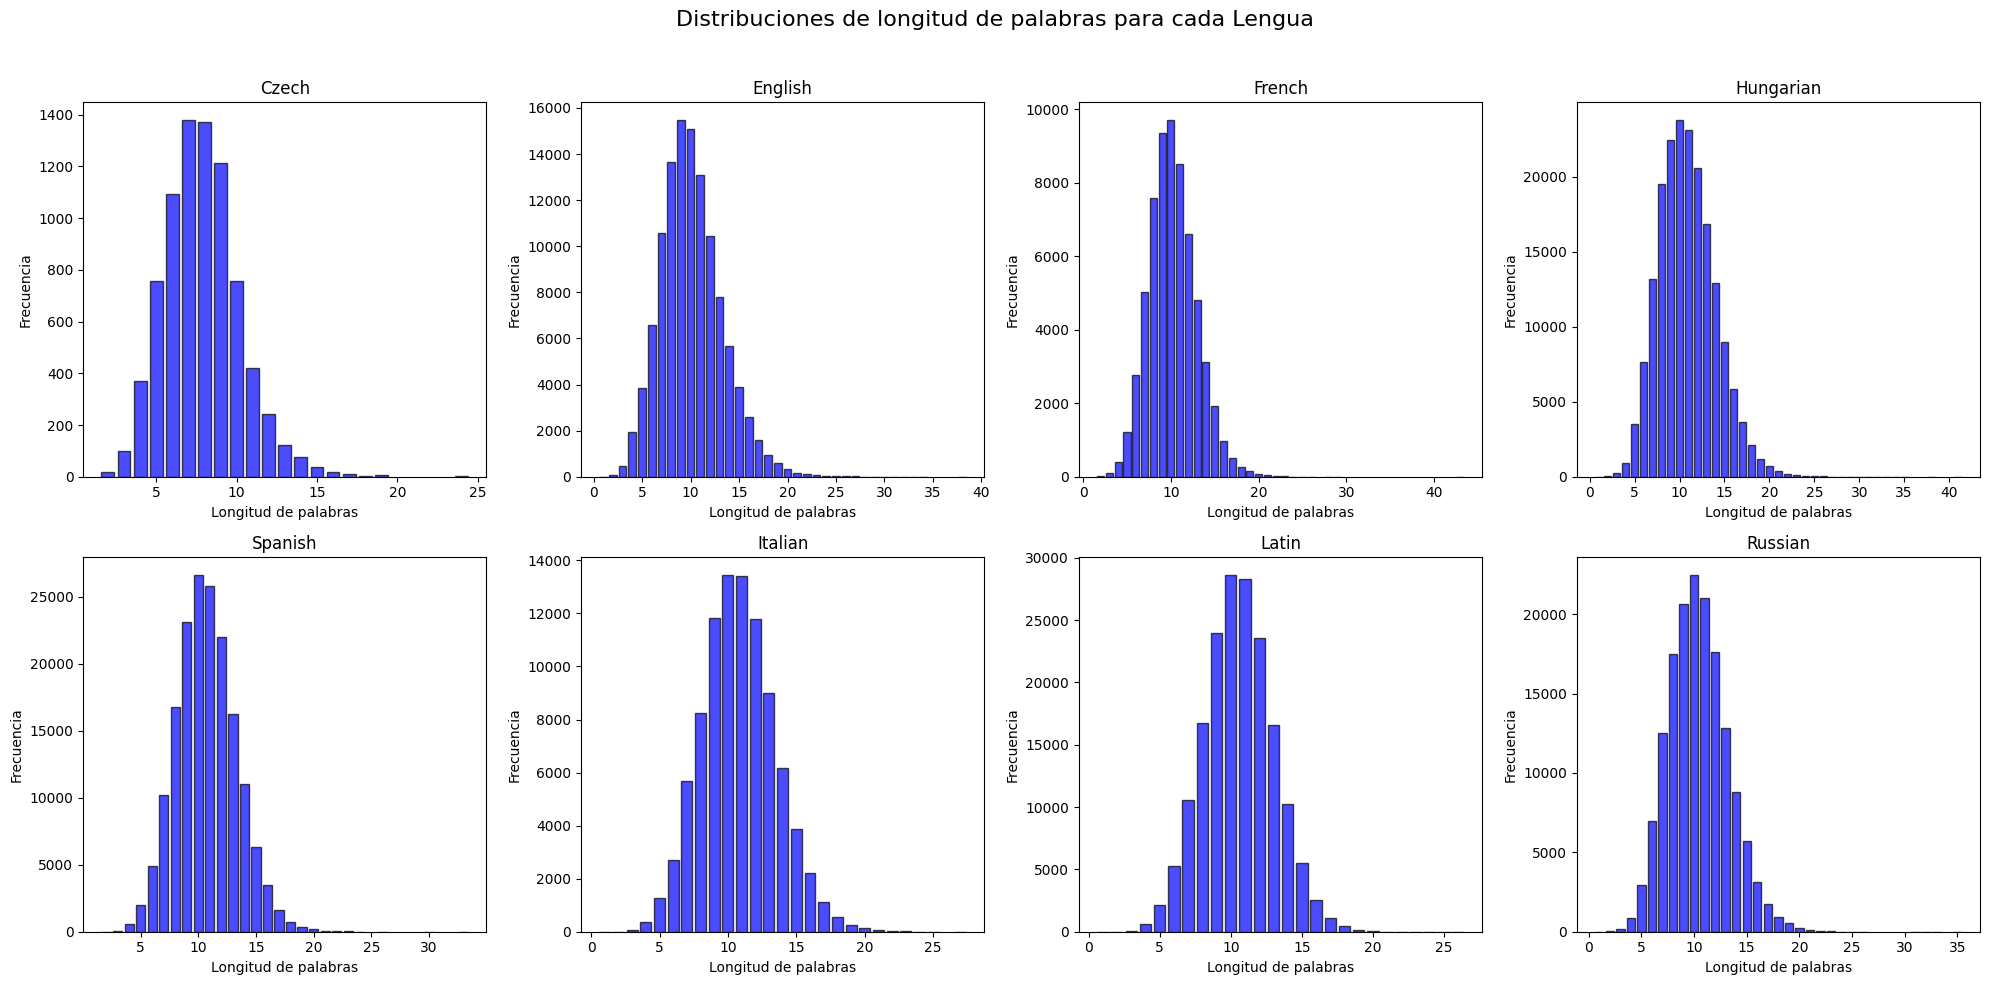

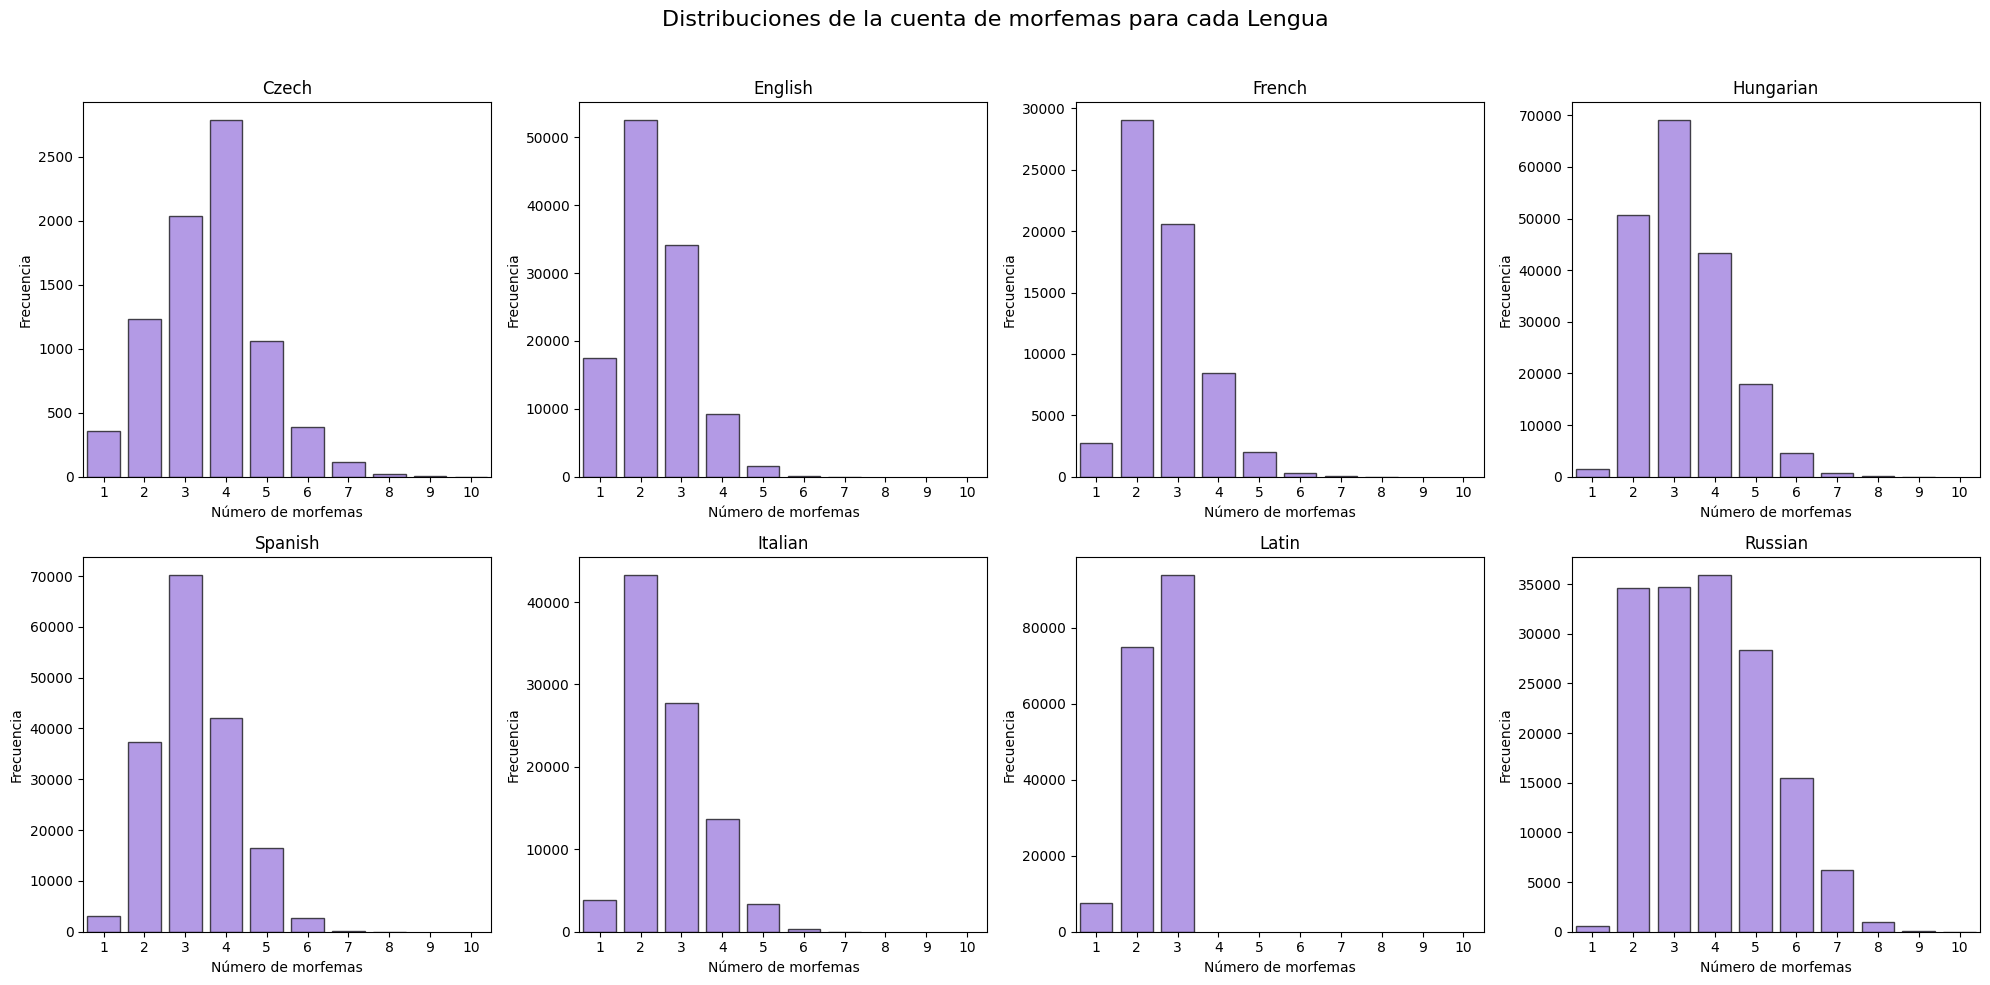

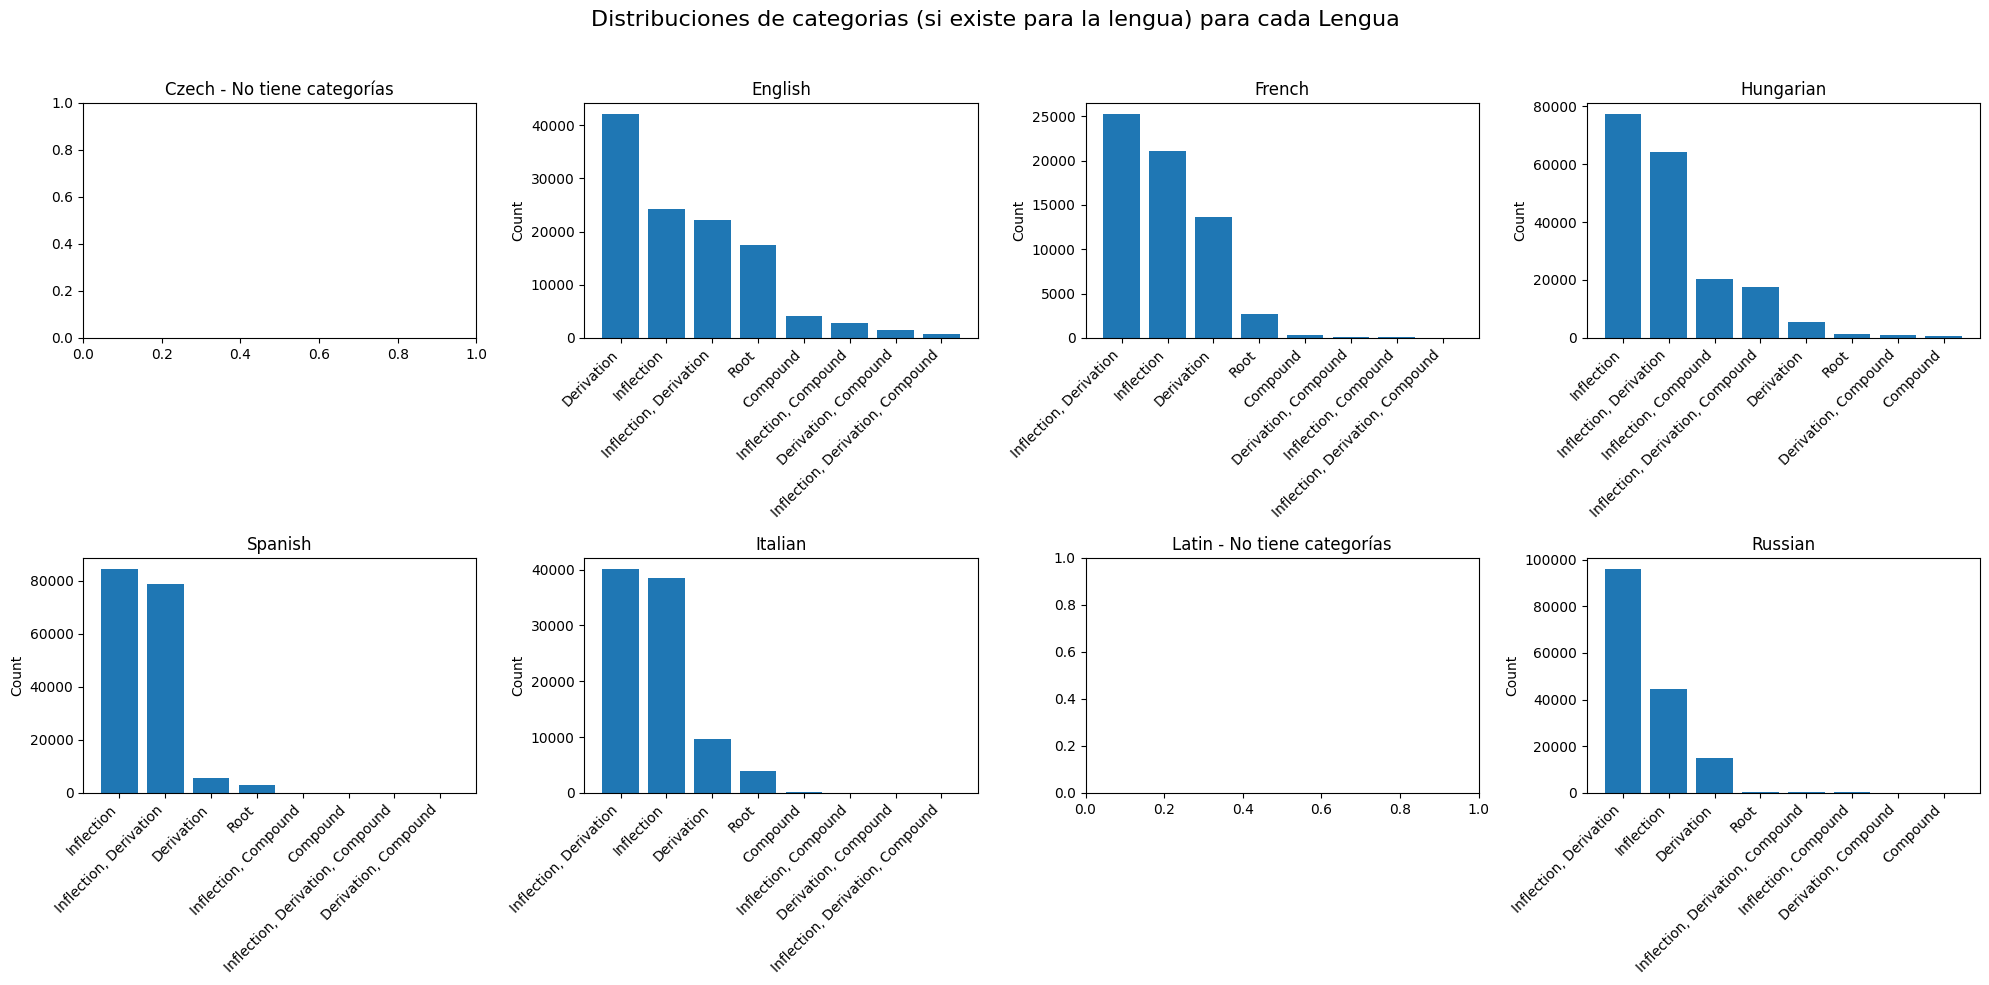

In [ ]:
df_idiomas = obtener_datos_idiomas()

graficas_longitud_palabras(df_idiomas)
print("\n\n")
graficas_morfemas(df_idiomas)
print("\n\n")
graficas_categorias(df_idiomas)

- Realice una función que imprima por cada lengua lo siguiente:
    - Total de palabras
    - La longitud de palabra promedio
    - La cuenta de morfemas promedio
    - La categoría más común


In [ ]:
# Para un solo idioma pero que se pueda generalizar, limitarse a lenguas con un alfabeto latino.
# basado en el rich
# 16 de febrero
from IPython.display import display, Markdown
import operator

def extraccion_informacion_idioma(df_idiomas):
  '''
  Función que extrae la información:
    Total de palabras
    La longitud de palabra promedio
    La cuenta de morfemas promedio
    La categoría más común
  Para todos los idiomas

  Input:
    df_idiomas: dataframe de todos los idiomas.

  Output:
    Retorna la información solicitada de cada idioma.
  '''
  for i, df_idioma in enumerate(df_idiomas):

    idioma = df_idioma['lang'].iloc[0]
    idioma = LANGS[idioma]

    total_palabras = len(df_idioma['words'].values) # Total de palabras
    longitud_promedio_palabras = np.array([len(valor) for valor in df_idioma['words'].values]).mean()
    longitud_promedio_morfemas = np.array([len(valor) for valor in df_idioma['morph'].values]).mean()

    dist_categorias = calcular_distribucion_categorias(df_idioma)
    keys = list(dict(dist_categorias).items())

    if keys[0][0] == 'NOT_FOUND':
      categoria_comun = 'No hay categorías para esta lengua.'
    else:
      categorias_mapeadas = {CATEGORIES[key]: count for key, count in dist_categorias.items() if key in CATEGORIES}
      categoria_comun = max(categorias_mapeadas.items(), key=operator. itemgetter(1))
      categoria_comun = categoria_comun[0]

    # Texto a imprimir
    text = f"## **Informacion extraída para el lenguaje: {idioma}** \n- **Total de palabras:** {total_palabras} \n- **Longitud de palabra promedios:** {longitud_promedio_palabras} \n- **Cuenta de morfemas promedio:** {longitud_promedio_morfemas} \n- **Categoría más común:** {categoria_comun}\n\n---"

    # Display as Markdown
    display(Markdown(text))
  return

In [ ]:
df_idiomas = obtener_datos_idiomas()
extraccion_informacion_idioma(df_idiomas)

## **Informacion extraída para el lenguaje: Czech** 
- **Total de palabras:** 8000 
- **Longitud de palabra promedios:** 7.84275 
- **Cuenta de morfemas promedio:** 3.59075 
- **Categoría más común:** No hay categorías para esta lengua.

---

## **Informacion extraída para el lenguaje: English** 
- **Total de palabras:** 115126 
- **Longitud de palabra promedios:** 10.10949742021785 
- **Cuenta de morfemas promedio:** 2.353230373677536 
- **Categoría más común:** Derivation

---

## **Informacion extraída para el lenguaje: French** 
- **Total de palabras:** 63173 
- **Longitud de palabra promedios:** 10.203393854969686 
- **Cuenta de morfemas promedio:** 2.6686400835800104 
- **Categoría más común:** Inflection, Derivation

---

## **Informacion extraída para el lenguaje: Hungarian** 
- **Total de palabras:** 188074 
- **Longitud de palabra promedios:** 10.85869923540734 
- **Cuenta de morfemas promedio:** 3.2302816976296564 
- **Categoría más común:** Inflection

---

## **Informacion extraída para el lenguaje: Spanish** 
- **Total de palabras:** 172173 
- **Longitud de palabra promedios:** 10.688301882408972 
- **Cuenta de morfemas promedio:** 3.236227515347935 
- **Categoría más común:** Inflection

---

## **Informacion extraída para el lenguaje: Italian** 
- **Total de palabras:** 92304 
- **Longitud de palabra promedios:** 10.795523487606172 
- **Cuenta de morfemas promedio:** 2.682657306292252 
- **Categoría más común:** Inflection, Derivation

---

## **Informacion extraída para el lenguaje: Latin** 
- **Total de palabras:** 176467 
- **Longitud de palabra promedios:** 10.55255656865023 
- **Cuenta de morfemas promedio:** 2.4890036097400645 
- **Categoría más común:** No hay categorías para esta lengua.

---

## **Informacion extraída para el lenguaje: Russian** 
- **Total de palabras:** 156846 
- **Longitud de palabra promedios:** 10.409994516914681 
- **Cuenta de morfemas promedio:** 3.851561404179896 
- **Categoría más común:** Inflection, Derivation

---

- Con base en esta información elabore una conclusión lingüística sobre la morfología de las lenguas analizadas.
    
### EXTRA:

- Imprimir la [matríz de confusión](https://en.wikipedia.org/wiki/Confusion_matrix) para el etiquetador CRFs visto en clase y elaborar una conclusión sobre los resultados

## Informacion adicional

In [ ]:
import nltk

# Descargando el corpus cess_esp: https://www.nltk.org/book/ch02.html#tab-corpora
nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [ ]:
from nltk.corpus import cess_esp
# Cargando oraciones
corpora = cess_esp.tagged_sents()

In [ ]:
corpora[1]

[('Una', 'di0fs0'),
 ('portavoz', 'nccs000'),
 ('de', 'sps00'),
 ('EDF', 'np00000'),
 ('explicó', 'vmis3s0'),
 ('a', 'sps00'),
 ('EFE', 'np00000'),
 ('que', 'cs'),
 ('el', 'da0ms0'),
 ('proyecto', 'ncms000'),
 ('para', 'sps00'),
 ('la', 'da0fs0'),
 ('construcción', 'ncfs000'),
 ('de', 'sps00'),
 ('Altamira_2', 'np00000'),
 (',', 'Fc'),
 ('al', 'spcms'),
 ('norte', 'ncms000'),
 ('de', 'sps00'),
 ('Tampico', 'np00000'),
 (',', 'Fc'),
 ('prevé', 'vmm02s0'),
 ('la', 'da0fs0'),
 ('utilización', 'ncfs000'),
 ('de', 'sps00'),
 ('gas', 'ncms000'),
 ('natural', 'aq0cs0'),
 ('como', 'cs'),
 ('combustible', 'ncms000'),
 ('principal', 'aq0cs0'),
 ('en', 'sps00'),
 ('una', 'di0fs0'),
 ('central', 'ncfs000'),
 ('de', 'sps00'),
 ('ciclo', 'ncms000'),
 ('combinado', 'aq0msp'),
 ('que', 'pr0cn000'),
 ('debe', 'vmip3s0'),
 ('empezar', 'vmn0000'),
 ('a', 'sps00'),
 ('funcionar', 'vmn0000'),
 ('en', 'sps00'),
 ('mayo_del_2002', 'W'),
 ('.', 'Fp')]

In [ ]:
pip install sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:00


In [ ]:
import requests

def get_tags_map() -> dict:
    tags_raw = requests.get("https://gist.githubusercontent.com/vitojph/39c52c709a9aff2d1d24588aba7f8155/raw/af2d83bc4c2a7e2e6dbb01bd0a10a23a3a21a551/universal_tagset-ES.map").text.split("\n")
    tags_map = {line.split("\t")[0].lower(): line.split("\t")[1] for line in tags_raw}
    return tags_map

def map_tag(tag: str, tags_map=get_tags_map()) -> str:
    return tags_map.get(tag.lower(), "N/F")

def parse_tags(corpora: list[list[tuple]]) -> list[list[tuple]]:
    result = []
    for sentence in corpora:
        print
        result.append([(word, map_tag(tag)) for word, tag in sentence if tag not in ["Fp", "Fc", "Fpa", "Fpt"]])
    return result

corpora = parse_tags(corpora)

def word_to_features(sent, i):
    word = sent[i][0]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'prefix_1': word[:1],
        'prefix_2': word[:2],
        'suffix_1': word[-1:],
        'suffix_2': word[-2:],
        'word_len': len(word)
    }
    if i > 0:
        prev_word = sent[i - 1][0]
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_word.istitle()': prev_word.istitle(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    return features

# Extract features and labels
def sent_to_features(sent) -> list:
    return [word_to_features(sent, i) for i in range(len(sent))]

def sent_to_labels(sent) -> list:
    return [label for token, label in sent]


# Preparando datos para el CRF
X = [[word_to_features(sent, i) for i in range(len(sent))] for sent in corpora]
y = [[pos for _, pos in sent] for sent in corpora]


from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

assert len(X_train) + len(X_test) == len(corpora), "Something wrong with my split :("
assert len(y_train) + len(y_test) == len(corpora), "Something wrong with my split :("

from inspect import Attribute
from sklearn_crfsuite import CRF
# Initialize and train the CRF tagger: https://sklearn-crfsuite.readthedocs.io/en/latest/api.html
crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True, verbose=True)
try:
    crf.fit(X_train, y_train)
except AttributeError as e:
    print(e)

from sklearn.metrics import classification_report
y_pred = crf.predict(X_test)

# Flatten the true and predicted labels
y_test_flat = [label for sent_labels in y_test for label in sent_labels]
y_pred_flat = [label for sent_labels in y_pred for label in sent_labels]

# Evaluate the model
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
print(report)

loading training data to CRFsuite: 100%|██████████| 4824/4824 [00:02<00:00, 2367.74it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 67684
Seconds required: 0.566

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.60  loss=296361.69 active=66733 feature_norm=0.50
Iter 2   time=0.19  loss=274496.22 active=66451 feature_norm=0.43
Iter 3   time=0.20  loss=268124.40 active=66864 feature_norm=0.50
Iter 4   time=0.20  loss=259997.04 active=67083 feature_norm=0.64
Iter 5   time=0.30  loss=229759.34 active=66884 feature_norm=1.46
Iter 6   time=0.28  loss=192769.26 active=67105 feature_norm=2.81
Iter 7   time=0.28  loss=162202.75 active=67202 feature_norm=4.47
Iter 8   time=0.29  loss=135392.33 active=67332 feature_norm=5.69
Iter 9   time=0.28  loss=114697.04 active=67160 feature_norm=7.82
Iter 

## Aplicación

Text(0.5, 1.0, 'Matriz de Confusión para el etiquetador CRFs visto en clase ')

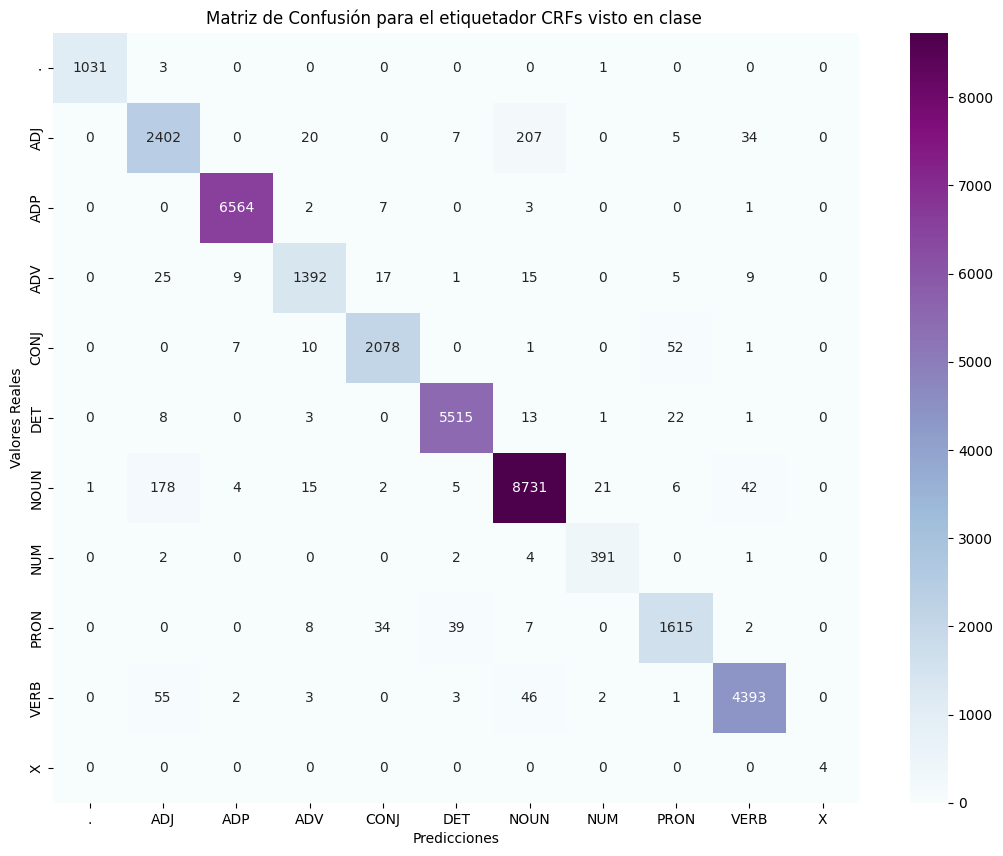

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = np.unique(y_test_flat)
confusion_m = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

plt.figure(figsize = (13,10))
sn.heatmap(confusion_m, annot=True, annot_kws={"size": 10}, cmap="BuPu", fmt="g", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión para el etiquetador CRFs visto en clase ")